Steps taken:

1) Learn all required concepts, LOL :)
2) Import all the required libraries for this task
3) Import the dataset
4) Check the dataset for any incoherent data and clean it.
5) Import the images from the dataset
6) Split the data into two parts: Training and testing dataset
7) Undersample the training dataset(Takes too much ram :( )
8) Declare model. Train the model on the training dataset
9) Run the model on testing dataset.
10) Output the required metrics.

Note: 

1) I have taken 10/20 epochs since it takes a lot of time on my non CUDA laptop. Change to 50/100 if required.
2) Change the variables label_file and images_loc as suitable locations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler

import cv2

import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.regularizers import L2
from tensorflow.keras.preprocessing import image

label_file = './Data/label.csv'
images_loc = './Data/cells/'

2023-06-11 21:29:39.201419: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-11 21:29:39.324987: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-11 21:29:39.325863: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 21:29:40.272118: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Here, I have imported all libraries needed, and have some variables that I will use for importing data

<Axes: xlabel='class', ylabel='Count'>

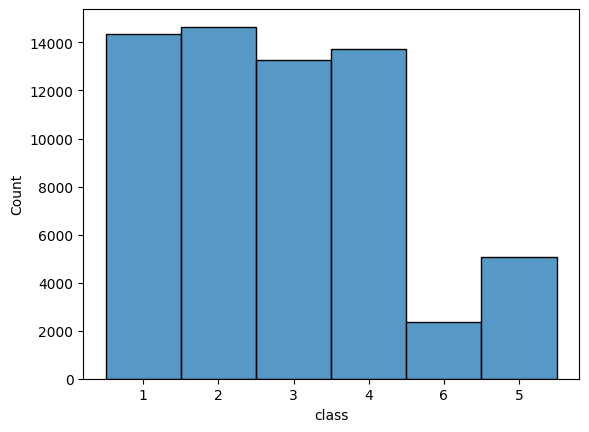

In [2]:
cols = ["name", "class"]
df = pd.read_csv(label_file, names = cols, header=None)

present = pd.DataFrame(os.listdir(images_loc), columns = cols[0:1])
df = df.merge(present,on=['name'])

sb.histplot(df["class"])

I have imported the data here using pandas, and have replaced the columns names with simple names. I also cleaned up the csv, removing all values not present in the cells folder (Not required though now).

In [3]:
def import_images(dataframe):
    preimage = []
    for index, row in dataframe.iterrows():
        img = cv2.imread(images_loc+row['name'])
        img = cv2.resize(img, (64, 64))
        img = img / 255.0
        img_array = image.img_to_array(img)
        preimage.append(img_array)
    
    return np.array(preimage)

images = import_images(df)
classification = np.array(df['class']).astype(int) - 1

Here, I have imported all images using the link in the dataframe, and stored all in an numpy array, and the labels in another numpy array

In [4]:
del(df)
del(present)

In [5]:
X, y = shuffle(images, classification)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

Here I have split the dataset into training and testing dataset

In [6]:
del(X)
del(y)
del(images)
del(classification)

<Axes: ylabel='Count'>

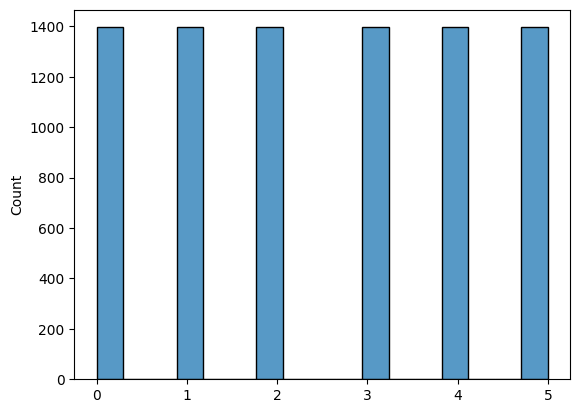

In [7]:

def scale_dataset(images, classi):
    x_dim = [images.shape[0], images.shape[1], images.shape[2], images.shape[3]]
    ros = RandomUnderSampler()
    X, Y = ros.fit_resample(images.reshape(images.shape[0], x_dim[1]*x_dim[2]*x_dim[3]), classi)
    X = X.reshape(X.shape[0], x_dim[1], x_dim[2], x_dim[3])
    return X, Y

X_train, y_train = scale_dataset(X_train, y_train)
sb.histplot(y_train)

I have undersampled the training dataset in order to have equal representation among the classes. (And to not crash my laptop :) )

In [8]:
model = Sequential([
    layers.Conv2D(32, (3, 3), kernel_regularizer=L2(0.001),
                  activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(16, (3, 3), kernel_regularizer=L2(0.001), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Flatten(),
    layers.Dense(24, activation='relu', kernel_regularizer=L2(0.001)),
    # layers.Dense(12, activation='relu', kernel_regularizer=L2(0.005)),
    layers.Dense(6, activation='sigmoid')])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Here is the model definition. 

In [9]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
262/262 [==============================] - 13s 49ms/step - loss: 1.3693 - accuracy: 0.4426 - val_loss: 1.2050 - val_accuracy: 0.5249
Epoch 2/20
262/262 [==============================] - 12s 47ms/step - loss: 1.1278 - accuracy: 0.5704 - val_loss: 1.1138 - val_accuracy: 0.5640
Epoch 3/20
262/262 [==============================] - 12s 47ms/step - loss: 1.0174 - accuracy: 0.6256 - val_loss: 1.0540 - val_accuracy: 0.6149
Epoch 4/20
262/262 [==============================] - 12s 47ms/step - loss: 0.9239 - accuracy: 0.6757 - val_loss: 0.9572 - val_accuracy: 0.6533
Epoch 5/20
262/262 [==============================] - 12s 47ms/step - loss: 0.8642 - accuracy: 0.6964 - val_loss: 0.8658 - val_accuracy: 0.7080
Epoch 6/20
262/262 [==============================] - 12s 46ms/step - loss: 0.8192 - accuracy: 0.7182 - val_loss: 0.8530 - val_accuracy: 0.7114
Epoch 7/20
262/262 [==============================] - 12s 46ms/step - loss: 0.7937 - accuracy: 0.7320 - val_loss: 0.8718 - val_accuracy:

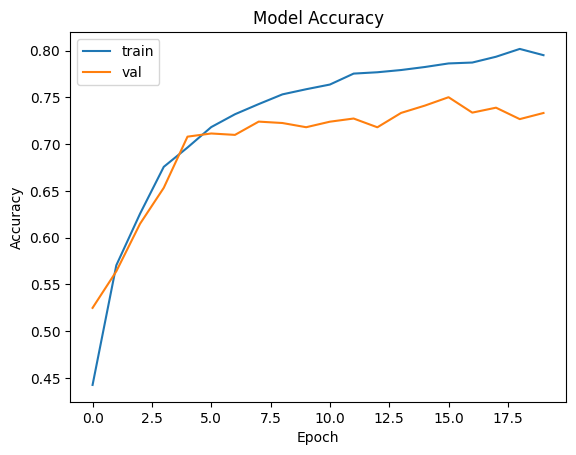

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','val'], loc='upper left')


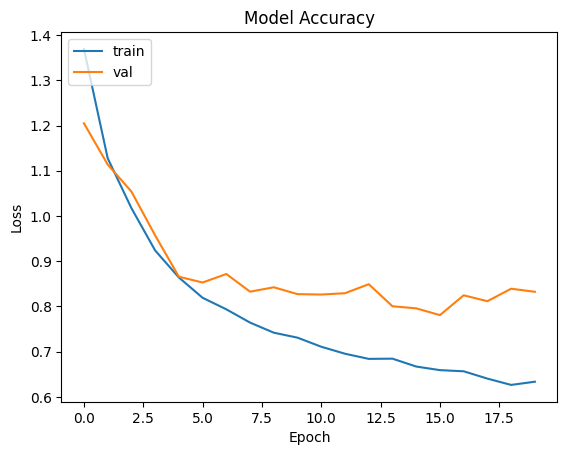

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','val'], loc='upper left')

Plotted Graphs of Accuracy and Loss vs Epochs for training and validation dataset

In [12]:
y_pred = model.predict(X_test)
y_pred

397/397 [==============================] - 3s 7ms/step


array([[3.33876222e-01, 6.52160048e-01, 1.01175211e-01, 1.54250249e-01,
        1.03795595e-01, 6.24926388e-02],
       [2.69126613e-03, 9.52480435e-01, 9.73408103e-01, 9.90427256e-01,
        1.54174231e-05, 1.95115190e-02],
       [3.53376119e-04, 9.67831492e-01, 9.86617684e-01, 9.98778999e-01,
        6.37083758e-07, 6.69972459e-03],
       ...,
       [1.64718833e-02, 3.59919667e-01, 9.92675066e-01, 9.19724882e-01,
        2.55539926e-04, 3.59709520e-04],
       [3.80172610e-01, 5.64320445e-01, 7.01512575e-01, 4.77362663e-01,
        4.13460322e-02, 1.02335261e-02],
       [5.80747744e-14, 9.99964654e-01, 1.00000000e+00, 1.00000000e+00,
        5.84294600e-24, 3.98825917e-10]], dtype=float32)

Here, I have predicted the values for the testing dataset.

In [13]:
y_predict = []
for i in range(len(y_pred)):
    y_predict.append(np.argmax(y_pred[i]))

y_predict = np.array(y_predict)

print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      2810
           1       0.77      0.56      0.65      2978
           2       0.74      0.79      0.76      2616
           3       0.82      0.73      0.77      2812
           4       0.58      0.78      0.67       992
           5       0.58      0.91      0.71       481

    accuracy                           0.73     12689
   macro avg       0.70      0.76      0.72     12689
weighted avg       0.74      0.73      0.73     12689



Here, I have printed the classification report.